In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
from PIL import Image

In [59]:
blind_img_list = []
rgb_list = []
gray_list = []
hsv_list = []

for i in range(0, 11):
    blind_img = cv2.imread('corneal input/scar_input/Corneal scar_d'+str(i)+'.png')
    blind_img_list.append(blind_img)
    rgb_list.append(cv2.cvtColor(blind_img, cv2.COLOR_BGR2RGB))
    gray_list.append(cv2.cvtColor(blind_img, cv2.COLOR_BGR2GRAY))
    hsv_list.append(cv2.cvtColor(blind_img, cv2.COLOR_BGR2HSV))

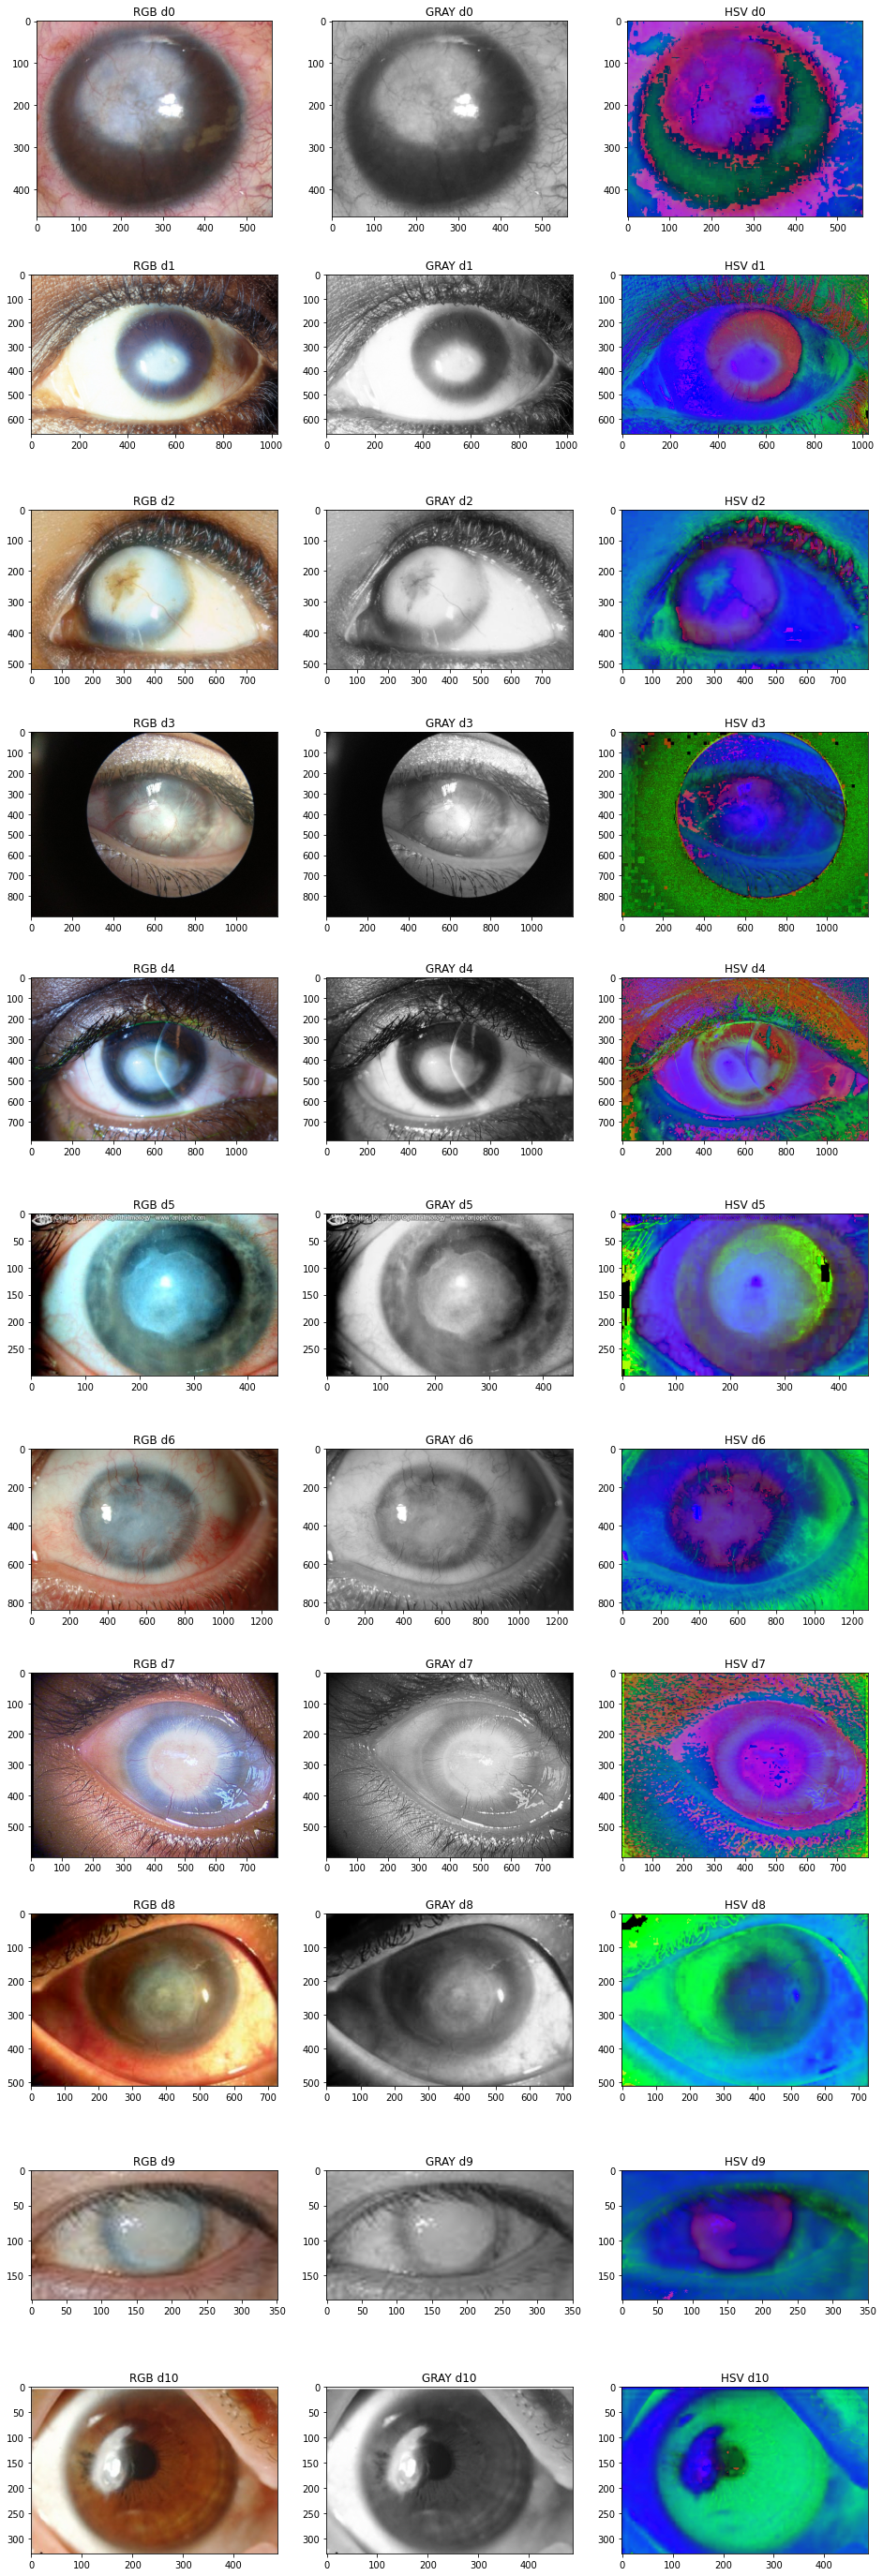

In [85]:
fig, axs = plt.subplots(11, 3)
fig.set_size_inches(16, 50)

for i in range(len(blind_img_list)):
    axs[i, 0].imshow(rgb_list[i])
    axs[i, 0].set_title('RGB d'+str(i))
    axs[i, 1].imshow(gray_list[i], cmap='gray', vmin=0, vmax=255)
    axs[i, 1].set_title('GRAY d'+str(i))
    axs[i, 2].imshow(hsv_list[i], cmap='hsv')
    axs[i, 2].set_title('HSV d'+str(i))

In [129]:
def detect_circles(hsv_img):
    
    detected_circles = None
    acc_threshold = 30
    while(detected_circles is None):
        
        detected_circles = cv2.HoughCircles(hsv_img[:,:,0],
                                 cv2.HOUGH_GRADIENT, 1, gray_b.shape[1], param1 = 15,
                                 param2 = acc_threshold, minRadius = int(gray_b.shape[1]/3), maxRadius = 0)
        acc_threshold -= 1
        
    return acc_threshold, detected_circles

In [130]:
def draw_circles(detected_circles, rgb):
    if detected_circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))
        cir_img = rgb.copy()

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]

            # Draw the circumference of the circle.
            cv2.circle(cir_img, (a, b), r, (0, 255, 0), 2)
            
    return cir_img

In [155]:
# minimum_circle_size: this is the range of possible circle in pixels you want to find
# maximum_circle_size: maximum possible circle radius size you're willing to find in pixels
# max_guess_accumulator_array_threshold: minimum of 1, no maximum, (max 300?) the quantity of votes 
                                         #needed to qualify for a circle to be found.

def detect_circles(hsv_img, minimum_circle_size, maximum_circle_size, number_of_circles_expected, max_guess_accumulator_array_threshold):
    circles = None

    guess_dp = 1.0

    breakout = False

    circleLog = []

    guess_accumulator_array_threshold = max_guess_accumulator_array_threshold

    while guess_accumulator_array_threshold > 1 and breakout == False:
        #start out with smallest resolution possible, to find the most precise circle, then creep bigger if none found
        guess_dp = 1.0
        while guess_dp < 9 and breakout == False:
            guess_radius = maximum_circle_size
            while True:

                #HoughCircles algorithm isn't strong enough to stand on its own if you don't
                #know EXACTLY what radius the circle in the image is, (accurate to within 3 pixels) 
                #If you don't know radius, you need lots of guess and check and lots of post-processing 
                #verification.  Luckily HoughCircles is pretty quick so we can brute force.

                circles = cv2.HoughCircles(hsv_img[:,:,0], 
                    cv2.HOUGH_GRADIENT, 
                    dp=guess_dp,               #resolution of accumulator array.
                    minDist=100,                #number of pixels center of circles should be from each other, hardcode
                    param1=50,
                    param2=guess_accumulator_array_threshold,
                    minRadius=(guess_radius-3),    #HoughCircles will look for circles at minimum this size
                    maxRadius=(guess_radius+3)     #HoughCircles will look for circles at maximum this size
                    )

                if circles is not None:
                    if len(circles[0]) == number_of_circles_expected:
                        circleLog.append(copy.copy(circles))
                    break
                    circles = None
                guess_radius -= 5 
                if guess_radius < minimum_circle_size:
                    break;

            guess_dp += 1.5

        guess_accumulator_array_threshold -= 2
        
    #Return the circleLog with the highest accumulator threshold
    return circleLog

In [156]:
def draw_circles(circleLog, orig_img):
    # ensure at least some circles were found
    for cir in circleLog:
        # convert the (x, y) coordinates and radius of the circles to integers
        output = np.copy(orig_img)

        if (len(cir) > 1):
            exit()

        print(cir[0, :])

        cir = np.round(cir[0, :]).astype("int")

        for (x, y, r) in cir:
            cv2.circle(output, (x, y), r, (0, 0, 255), 2)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

        return output

[[262.  242.  223.6]]
[[678.  430.  316.6]]
[[326.  282.  174.6]]
[[682.  386.  420.6]]
[[530.  286.  397.6]]
[[222.75 134.75 149.75]]
[[514.  382.  234.6]]
[[510.  294.  195.6]]
[[234.5  234.5  234.45]]
[[166.   70.   72.6]]
[[164.5  164.5  164.45]]


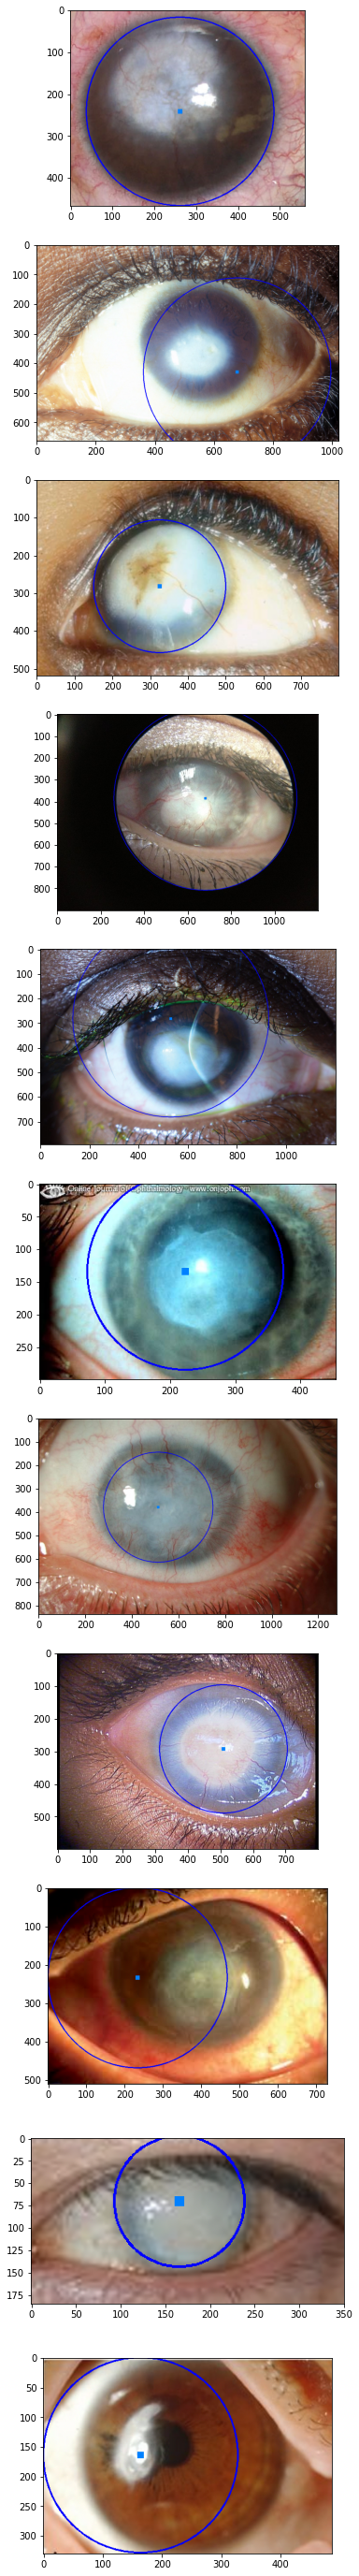

In [159]:
# max_circle_size = image_width/2
circle_list = []
circle_img_list = []
fig, axs = plt.subplots(11)
fig.set_size_inches(6, 50)

for i in range(len(blind_img_list)):
    circles = detect_circles(hsv_list[i], int(rgb_list[i].shape[0]/4), int(rgb_list[i].shape[0]/2), 1, 100)
    circle_list.append(circles)
    circle_img = draw_circles(circles, rgb_list[i])
    circle_img_list.append(circle_img)
    axs[i].imshow(circle_img)

[[262.  242.  222.6]]
[[518.  322.  282.6]]
[[326.  282.  173.6]]
[[682.  386.  420.6]]
[[746.  722.  685.6]]
[[304.5  297.5  299.45]]
[[514.  382.  234.6]]
[[510.  294.  195.6]]
[[479.5  479.5  479.45]]
[[154.   86.   55.6]]
[[283.5  332.5  329.45]]


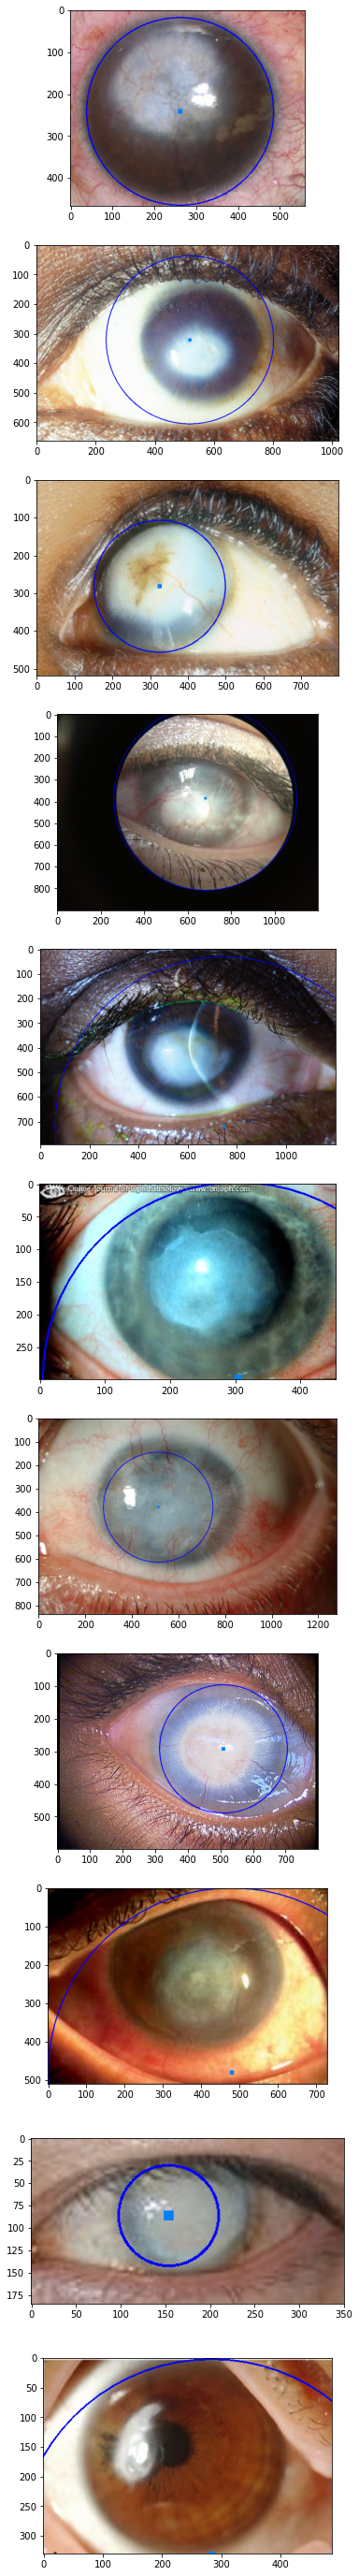

In [160]:
# max_circle_size = image_width
circle_list = []
circle_img_list = []
fig, axs = plt.subplots(11)
fig.set_size_inches(6, 50)

for i in range(len(blind_img_list)):
    circles = detect_circles(hsv_list[i], int(rgb_list[i].shape[0]/4), int(rgb_list[i].shape[0]), 1, 100)
    circle_list.append(circles)
    circle_img = draw_circles(circles, rgb_list[i])
    circle_img_list.append(circle_img)
    axs[i].imshow(circle_img)

In [161]:
blind_img = cv2.imread('corneal_scar_sample_2.jpeg')
output = blind_img.copy()

In [162]:
rgb_b = cv2.cvtColor(blind_img, cv2.COLOR_BGR2RGB)
gray_b = cv2.cvtColor(blind_img, cv2.COLOR_BGR2GRAY)
hsv_b = cv2.cvtColor(blind_img, cv2.COLOR_BGR2HSV)

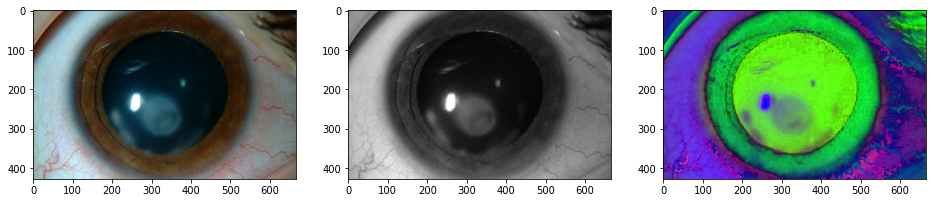

In [163]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16, 9)
axs[0].imshow(rgb_b)
axs[1].imshow(gray_b, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(hsv_b, cmap='hsv')

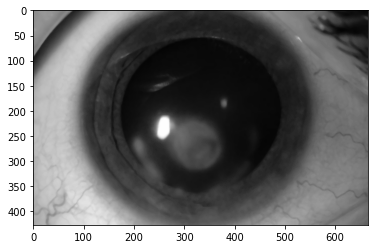

In [164]:
gray_blurred = cv2.medianBlur(gray_b, 5)
plt.imshow(gray_blurred, cmap='gray', vmin=0, vmax=255)

In [238]:
circles = cv2.HoughCircles(hsv_b[:,:,0], cv2.HOUGH_GRADIENT, 1, gray_b.shape[0], param1=50, param2=30, minRadius=0,maxRadius=0)
circles

array([[[328.5, 211.5, 152.8]]], dtype=float32)

In [239]:
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
circles

array([[328, 212, 153]])

In [240]:
#blind
max_c = [[circles[0]]]
max_c

[[array([328, 212, 153])]]

In [241]:
def draw_circles(detected_circles, org_img):
    if detected_circles is not None:

        # Convert the circle parameters a, b and r to integers.
        detected_circles = np.uint16(np.around(detected_circles))
        cir_img = org_img.copy()

        for pt in detected_circles[0, :]:
            a, b, r = pt[0], pt[1], pt[2]

            # Draw the circumference of the circle.
            cv2.circle(cir_img, (a, b), r, (0, 255, 0), -1)
            
    return cir_img

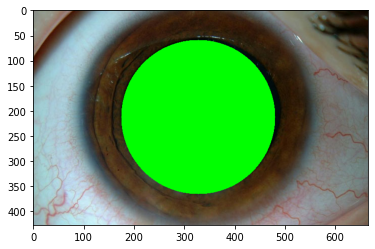

In [242]:
test = draw_circles(max_c, rgb_b)

plt.imshow(test)
plt.show()

In [243]:
cv2.imwrite("best_circle.jpg", test)

True

In [244]:
test_cri = cv2.imread('best_circle.jpg')

In [245]:
gray_test_cri = cv2.cvtColor(test_cri, cv2.COLOR_BGR2HSV)

In [246]:
binary = cv2.inRange(gray_test_cri, (0, 255,0), (79, 255, 255))

In [247]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [248]:
contour = max(contours, key=lambda x: cv2.contourArea(x))

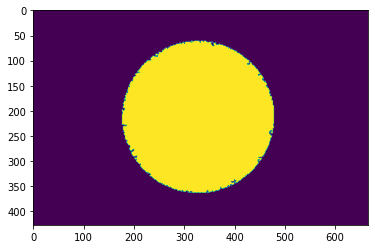

In [249]:
mask = np.zeros_like(binary)
cv2.drawContours(mask, [contour], -1, color=255, thickness=-1)
plt.imshow(mask)
plt.show()

In [250]:
cv2.imwrite("mask_test.jpg", mask)

True

In [251]:
img_mask_test = cv2.imread("mask_test.jpg")

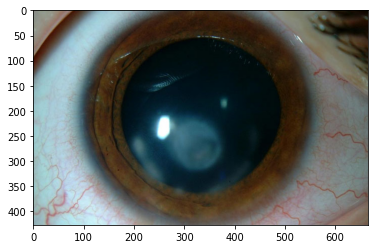

In [252]:
plt.imshow(rgb_b)
plt.show()

In [253]:
crip_f = cv2.bitwise_and(rgb_b, rgb_b, mask=mask)

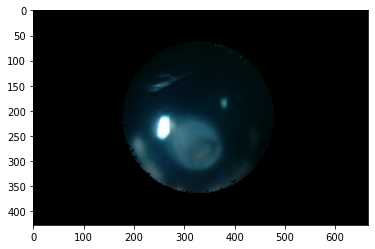

In [254]:
plt.imshow(crip_f)
plt.show()

In [255]:
gray_masked = cv2.cvtColor(crip_f, cv2.COLOR_BGR2GRAY)

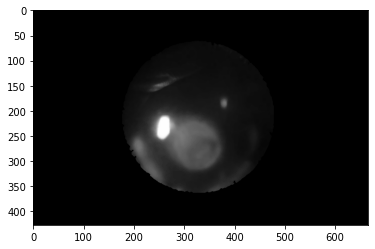

In [256]:
gray_masked_blurred = cv2.medianBlur(gray_masked , 5)
plt.imshow(gray_masked_blurred, cmap='gray', vmin=0, vmax=255)

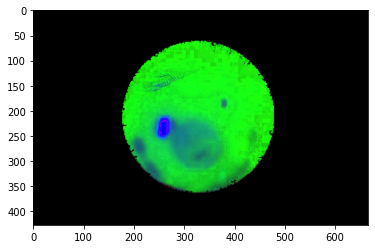

In [257]:
img_hsv = cv2.cvtColor(crip_f, cv2.COLOR_BGR2HSV)
plt.imshow(img_hsv)

In [258]:
#K-means Clustering to Find Scar Area
#Method 1 - K-means clustering using Scikit

In [259]:
from sklearn.cluster import KMeans

In [260]:
clt = KMeans(n_clusters=3)
clt.fit(img_hsv.reshape(-1, 3))

KMeans(n_clusters=3)

In [261]:
clt.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [262]:
clt.cluster_centers_

array([[4.62059341e-02, 5.92055970e-02, 5.50284719e-02],
       [2.30211094e+01, 2.35111841e+02, 2.93538170e+01],
       [2.40092716e+01, 1.46339171e+02, 1.04285844e+02]])

In [263]:
def show_img_compar(img_1, img_2 ):
    f, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis('off') #hide the axis
    ax[1].axis('off')
    f.tight_layout()
    plt.show()

In [264]:
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

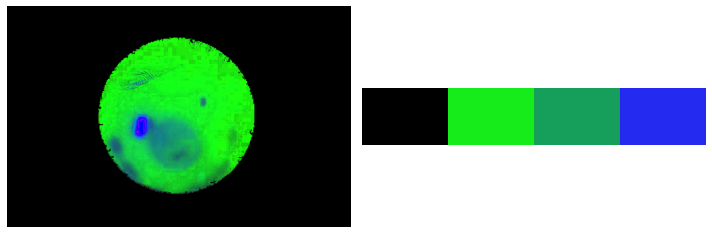

In [266]:
clt = KMeans(n_clusters=4)
clt_1 = clt.fit(img_hsv.reshape(-1, 3))
show_img_compar(img_hsv, palette(clt_1))

In [267]:
#Method 2 - K-means clustering using CV2

In [268]:
def quantimage(image,k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img, center

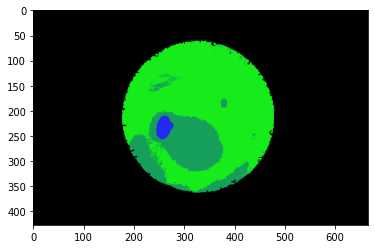

In [269]:
q_img, clt_colors = quantimage(img_hsv,4)
plt.imshow(q_img)
plt.show()

In [270]:
threshold_img = q_img.copy()

In [274]:
threshold_value = clt_colors[3]

In [275]:
threshold_img[q_img == threshold_value] = 255
threshold_img[q_img != threshold_value] = 0

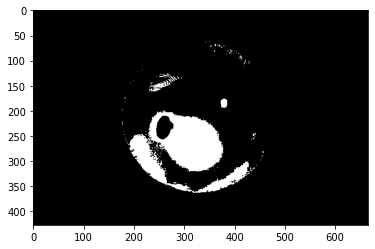

In [276]:
plt.imshow(threshold_img)
plt.show()

In [277]:
threshold_gray = cv2.cvtColor(threshold_img, cv2.COLOR_BGR2GRAY)

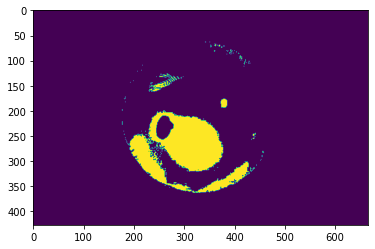

In [278]:
plt.imshow(threshold_gray)
plt.show()

In [279]:
crip_ff = cv2.bitwise_and(crip_f, crip_f, mask=threshold_gray)

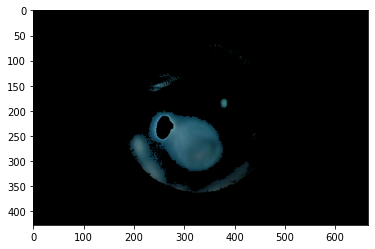

In [280]:
plt.imshow(crip_ff)
plt.show()

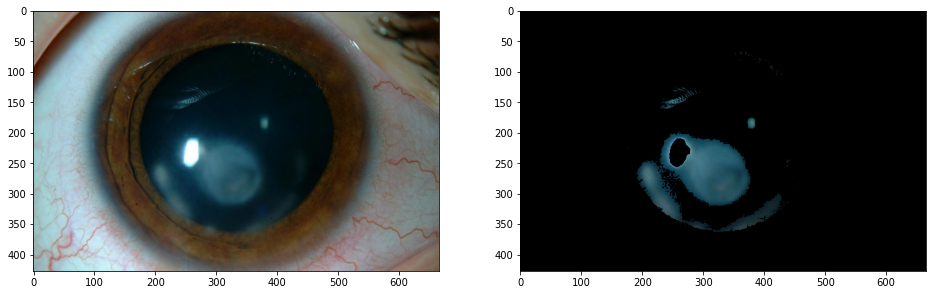

In [281]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(16, 9)
axs[0].imshow(rgb_b)
axs[1].imshow(crip_ff)